# 3D Analysis Example
Files for this analysis can be downloaded from [here](https://drive.proton.me/urls/JSGH2TARWW#sgLZ8E2GvsBZ) using the standard VERITAS password.

In this example we'll perform a 3D analysis of a crowded FoV to obtain the significances of each source and estimate the energy spectra. 

We'll be analyzing data on LS 5039, a point source which has the extended source HESS J1825-137 within the FoV.

e'll perform the following steps:
1. [Define our analysis using a config](#config)
2. [Extract the data into a dataset](#extraction)
3. [Define the models for each source](#source-model)
4. [Fit the various sources iteratively to estimate the significance](#fitting)
    * [Fit the background model to the FoV](#fitting-background)
    * [Fit LS 5039 (point source)](#fitting-LS5039)
    * [Fit HESS J1825-137 (extended source)](#fitting-hess)
5. [Use the signifiance distibution to check the quality of the fit](#sigdist)
7. [Plot the enegy spectra for each source](#spectra)

In [1]:
from pathlib import Path
import numpy as np
from scipy.stats import norm
import astropy.units as u
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    PowerLawSpectralModel,
    FoVBackgroundModel,
    Models,
    PointSpatialModel,
    GeneralizedGaussianSpatialModel,
    GaussianSpatialModel,
    SkyModel,
)

# Defining a config
<a id='config'></a>

Using an `AnalysisConfig` we ca  define various parameters for the analysis. Here are some of the important one:
* `config.observations.obs_cone` This is the cone in the sky for which we search for observations. We are defining a region of 3.5 degrees centred on the source location. Falling within this cone will be included
* `config.datasets.geom.wcs` This is our "world coordinate system (WCS)". This defines the scales used when creating sky maps. Here we define the WCS to be centred on the source position. We make it large enough, giving it a widght and height of 5 degrees and set the binning of the wcs to 0.02 degrees.
* `config.datasets.geom.selection.offset_max` This select the maximum offset a run can have when being included in the analysis. 
* `config.datasets.safe_mask.parameters` This sets some parameters of "safe" analysis ranges. Here we'll define the energy range threshold at 15% of the maximum effective area. We'll also set the maximum offset and event can have to be 1.5 degrees
* `config.datasets.safe_mask.methods` This is setting the methods we're using to define our safe analysis regieme.
* `config.datasets.geom.axes.energy` This sets the energy axes for the analysis.
* `config.datasets.background.exclusion` This sets a previously generated exclusion mask to be loaded in

In [2]:
config = AnalysisConfig()

source_pos = SkyCoord.from_name("LS 5039")

# Select observations - 2.5 degrees from the source position
config.observations.datastore = "./moderate2tel/"
config.observations.obs_cone = {
    "frame": "icrs",
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "radius": 2 * u.deg,
}

config.datasets.type = "3d"
config.datasets.geom.wcs.skydir = {
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "frame": "icrs",
}  
config.datasets.type = "3d"
config.datasets.geom.wcs.skydir = {
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "frame": "icrs",
}  
# The WCS geometry - centered on MSH 15-52
config.datasets.geom.wcs.width = {"width": "5.0 deg", "height": "5.0 deg"}
config.datasets.geom.wcs.binsize = "0.01 deg"

# Cutout size (for the run-wise event selection)
config.datasets.geom.selection.offset_max = 3.5 * u.deg
config.datasets.safe_mask.parameters = {"aeff_percent":0.15, "offset_max" : 1.5*u.deg}
config.datasets.safe_mask.methods = ["aeff-max", "offset-max"]

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.5 TeV"
config.datasets.geom.axes.energy.max = "100 TeV"
config.datasets.geom.axes.energy.nbins = 10

config.datasets.background.method = "fov_background"
config.datasets.background.parameters = {"method": "scale"}

config.datasets.background.exclusion = (
    "exclusion_mask.fits"
)


print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: moderate2tel
        obs_ids: []
        obs_file: null
        obs_cone: {frame: icrs, lon: 276.56273398 deg, lat: -14.84840202 deg, radius: 2.0
                deg}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 3d
        stack: true
        geom:
            wcs:
                skydir: {frame: icrs, lon: 276.56273398 deg, lat: -14.84840202 deg}
                binsize: 0.01 deg
                width: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 3.5 deg}
            axes:
                energy: {min: 0.5 TeV, max: 100.0 TeV, nbins: 10}
                energy_true: {min: 0.5 TeV, max: 20.0 TeV, nbins: 16}
      

We can perform either a stacked or a joint analysis.
* In a stacked analysis all of the observations are combined into a single object with the model optimized on that object (with run-wise IRFs considered). In a stacked analysis the background is normalized to a global best fit.
* In a joint analysis all of the observations are kept seperate, with the model optimized by taking the run-wise likelihoods to create a total fit statistic. Using a joint analysis we can allow the run-wise background to be optimized for each run.

Stacked analysis is far quicker than a joint analysis, however less sensitive to background variations. A joint analysis, while more sensitive to background variations, can be dominated by source variablity. 

For a constant flux source with non-varying background these should yeild statistically consistent results. Discrepencies may arise due to run-wise effects such as variability.

In [3]:
config_stack = config.copy(deep=True)
config_stack.datasets.stack = True

config_joint = config.copy(deep=True)
config_joint.datasets.stack = False

# To prevent unnecessary cluttering, we write it in a separate folder.
path = Path("analysis_3d")
path.mkdir(exist_ok=True)
config_stack.write(path=path / "config_stack.yaml", overwrite=True)

# Extracting Data
<a id='extraction'></a>

Using the config we just defined, we'll search observations matching our criteria. We'll also start the process of extracting the data. This can take a while for longer run lists

In [4]:
# Reading yaml file:
config_stacked = AnalysisConfig.read(path=path / "config_stack.yaml")

analysis_stacked = Analysis(config_stacked)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


In [5]:
analysis_stacked.get_observations()

# run data reduction
analysis_stacked.get_datasets()

Fetching observations.
Observations selected: 17 out of 17.
Number of selected observations: 17
Creating reference dataset and makers.
Creating the background Maker.
Start the data reduction loop.
Computing dataset for observation 69054
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 69123
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 69187
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 69188
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 69202
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 69203
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing dataset for observation 73193
Running MapDatasetMaker
Running SafeMaskMaker
Running FoVBackgroundMaker
Computing da

In [6]:
dataset_stacked = analysis_stacked.datasets["stacked"]
print(dataset_stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 7666 
  Total background counts         : 6750.48
  Total excess counts             : 915.52

  Predicted counts                : 6750.48
  Predicted background counts     : 6750.48
  Predicted excess counts         : nan

  Exposure min                    : 7.89e+07 m2 s
  Exposure max                    : 7.96e+09 m2 s

  Number of total bins            : 2500000 
  Number of fit bins              : 1059597 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [7]:
dataset_stacked.counts.smooth(0.02 * u.deg).plot_interactive(add_cbar=True)
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [8]:
dataset_stacked.background.plot_interactive(add_cbar=True)
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

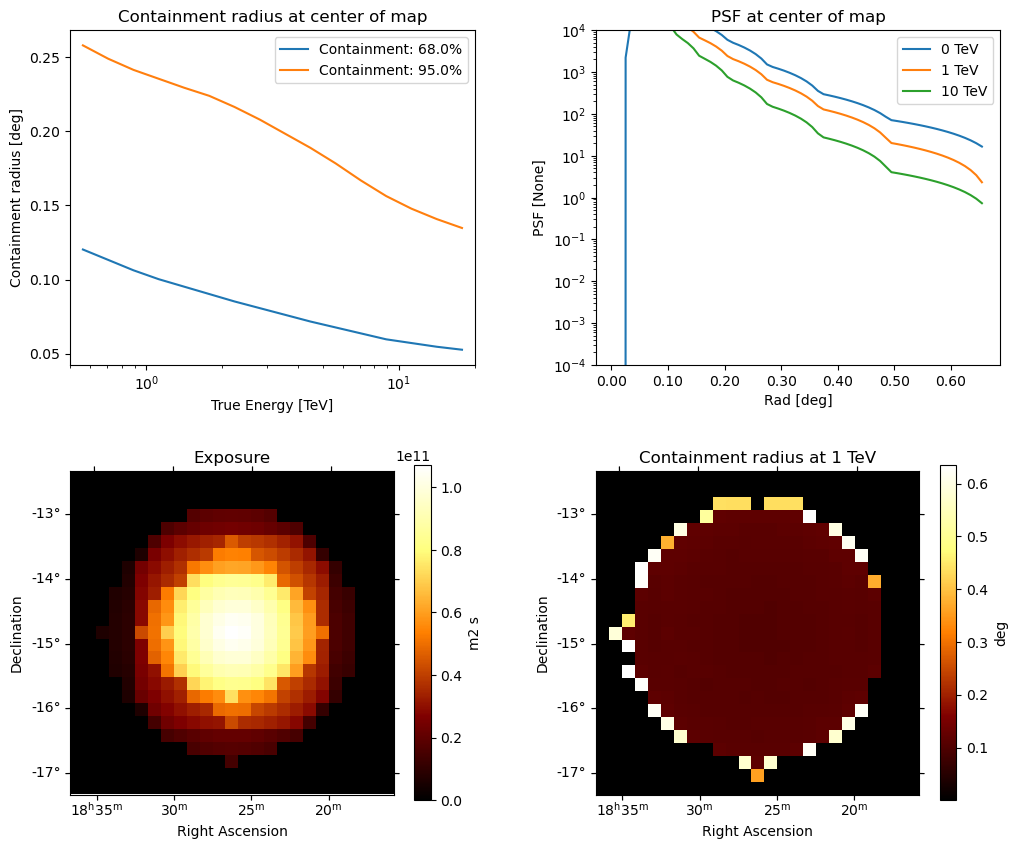

In [9]:
dataset_stacked.psf.peek()
plt.show()

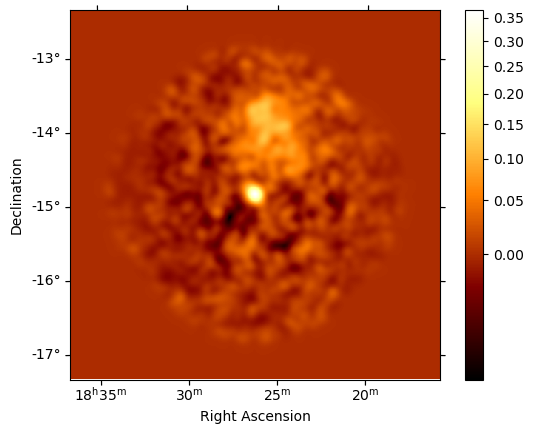

In [10]:
excess = dataset_stacked.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True)
plt.show()

# Defining source models
<a id='source-model'></a>

In 3D analysis models typically have 4 components:
* Background. In this example we'll use a `FoVBackgroundModel`. This will find the model by normalizing the bkgs to the FoV, excluding regions in our exclusion mask. This model has the parameters `norm` and `tilt`. `norm` is the normalization of the bkg. `tilt` is similar to a spectral index, allowing for energy response of the backgrounds to change.
* Spatial Models: These model the source morphology. In this example we'll use a  `PointSpatialModel` for LS 5039 and a `GaussianSpatialModel` for HESS J1825-137.
* Spectral Models: These model the energy spectrum of a source. In this example we'll use  a `PowerLawSpectralModel` for both sources.
* SkyModel: These combine a spatial and spectral model for a source.


In [11]:
dataset_stacked.mask_fit = dataset_stacked.counts.geom.energy_mask(
    energy_min=0.3 * u.TeV, energy_max=None
)

spatial_ls5039 = PointSpatialModel(
    lon_0 = source_pos.galactic.l.deg * u.deg,
    lat_0 = source_pos.galactic.b.deg * u.deg,
    frame="galactic"
)
spatial_ls5039.lat_0.frozen = True
spatial_ls5039.lon_0.frozen = True


spectral_model_ls5039 = PowerLawSpectralModel(
    index=2.3,
    amplitude=2.8e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
    # lambda_=0.02 / u.TeV,
)

model_ls5039 = SkyModel(
    spatial_model=spatial_ls5039,
    spectral_model=spectral_model_ls5039,
    name="LS 5039",
)


# Extended source
gauss_hess = GaussianSpatialModel(
    lon_0 = 276.26  * u.deg,
    lat_0 = -13.97* u.deg,
    sigma = 0.461 * u.deg,
    frame="fk5",
)


spectral_model_hess = PowerLawSpectralModel(
    index=2.38,
    amplitude=1.82e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.16 * u.TeV,
    # lambda_=0.02 / u.TeV,
)


model_hess = SkyModel(
    spatial_model=gauss_hess,
    spectral_model=spectral_model_hess,
    name="HESS J1825-137",
)

# Allow the normalization to vary, but fix the tilt
bkg_model = FoVBackgroundModel(dataset_name="stacked")
bkg_model.spectral_model.norm.value = 1.3
bkg_model.spectral_model.tilt.frozen = True


# Fitting the model
<a id='fitting'></a>

We'll iteratively fit the data by adding components to our model one by one

## Fitting the background
<a id='fitting-background'></a>

We'll start off by just fitting the background model.

In [13]:
models_stacked = Models([bkg_model])
dataset_stacked.models = models_stacked


In [14]:
fit_bkg = Fit(optimize_opts={"print_level": 1})
result_bkg = fit_bkg.run(datasets=[dataset_stacked])

Record the `total_stat`. This will the be $2\log\mathcal{L}$ for the background only model.

In [15]:
ts_bkg = result_bkg.total_stat
ts_bkg

71708.90896522689

The residual map is useful to see if there area any sources remaining in the FoV. We can see apoint source at the centre. This corresponds to LS 5039.

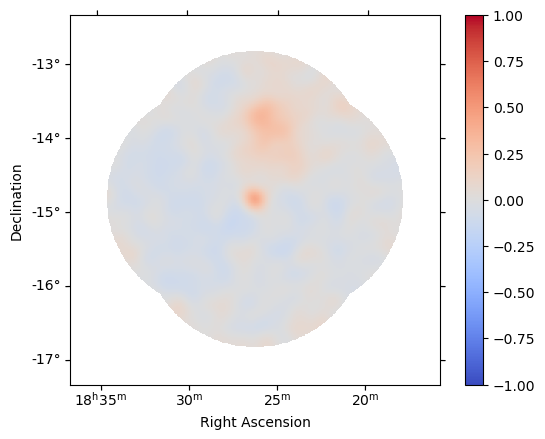

In [16]:
dataset_stacked.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-1, vmax=1)
plt.show()

In [17]:
display(models_stacked.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str11,str8,str9,float64,str3,float64,float64,float64,bool,bool,str1
stacked-bkg,spectral,norm,1.1356e+00,,1.297e-02,nan,nan,False,True,
stacked-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
stacked-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


## Fitting LS5039
<a id='fitting-LS5039'></a>

We'll add the model for LS 5039 to our total model. We'll freeze the spatial model, since we know the location of the point source.

In [18]:
models_stacked = Models([model_ls5039, bkg_model])
models_stacked[0].freeze("spatial")
dataset_stacked.models = models_stacked


In [19]:
fit_ls = Fit(optimize_opts={"print_level": 1})
result_ls = fit_ls.run(datasets=[dataset_stacked])

In [20]:
ts_ls = result_ls.total_stat
ts_ls

71457.67374872245

The significance of the improvement to the model can be used to estimate the significance of LS 5039. This is obtained from:

$$\sqrt{TS_{bkg} - TS_{LS5039}}$$

Where $TS_{bkg}$ is the test statistic of the background only model and $ TS_{LS5039}$ is the test statistic of the background + LS 5039 model.

In [21]:
sig_ls = np.sqrt(ts_bkg - ts_ls)
print(f"Sigificance = {sig_ls:0.2f} sigma")

Sigificance = 15.85 sigma


Looking at the residual map we can see a large extended source to the north of the map. This corresponds to HESS J1825-137.

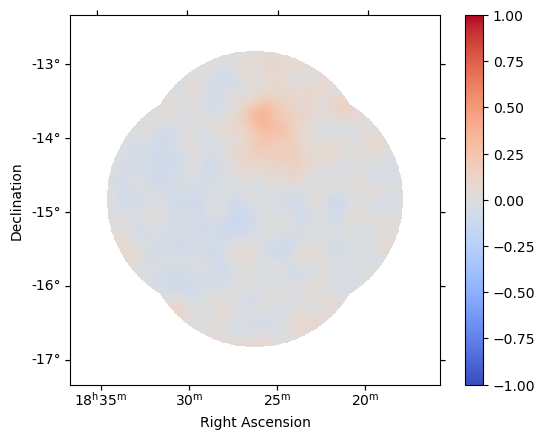

In [22]:
dataset_stacked.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-1, vmax=1)
plt.show()

In [23]:
display(models_stacked.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str11,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
LS 5039,spectral,index,2.2368e+00,,1.433e-01,nan,nan,False,False,
LS 5039,spectral,amplitude,2.2849e-12,TeV-1 s-1 cm-2,3.398e-13,nan,nan,False,True,
LS 5039,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
LS 5039,spatial,lon_0,1.6882e+01,deg,0.000e+00,nan,nan,True,False,
LS 5039,spatial,lat_0,-1.2892e+00,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,
stacked-bkg,spectral,norm,1.1142e+00,,1.293e-02,nan,nan,False,True,
stacked-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
stacked-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


## Fitting HESS J1825-137
<a id='fitting-hess'></a>

We'll now add the extended source HESS J1825 to our model. 

In doing so we'll unfreeze the background point source model (LS 5039) and allow them to be refit. It's good to constrain the fit range to help converge and avoid getting stuck in a local minima. 

In [24]:
models_stacked = Models([model_ls5039, model_hess, bkg_model])
models_stacked[0].unfreeze()
models_stacked[2].unfreeze()

models_stacked[1].spatial_model.parameters["lat_0"].min =  models_stacked[1].spatial_model.parameters["lat_0"].value - 0.1
models_stacked[1].spatial_model.parameters["lat_0"].max =  models_stacked[1].spatial_model.parameters["lat_0"].value + 0.1


models_stacked[1].spatial_model.parameters["lon_0"].min =  models_stacked[1].spatial_model.parameters["lon_0"].value - 0.1
models_stacked[1].spatial_model.parameters["lon_0"].max =  models_stacked[1].spatial_model.parameters["lon_0"].value + 0.1

dataset_stacked.models = models_stacked

In [25]:
fit_hess = Fit(optimize_opts={"print_level": 1})
result_hess = fit_hess.run(datasets=[dataset_stacked])

In [26]:
ts_hess = result_hess.total_stat
ts_hess

71041.91707845517

In [27]:
sig_hess = np.sqrt(ts_ls - ts_hess)
print(f"Sigificance = {sig_hess:0.2f} sigma")

Sigificance = 20.39 sigma


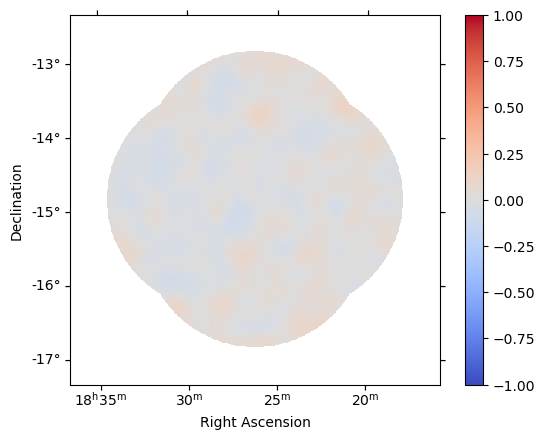

In [28]:
dataset_stacked.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-1, vmax=1)
plt.show()

In [29]:
display(models_stacked.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str14,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
LS 5039,spectral,index,2.2660e+00,,1.455e-01,nan,nan,False,False,
LS 5039,spectral,amplitude,2.3755e-12,TeV-1 s-1 cm-2,3.526e-13,nan,nan,False,True,
LS 5039,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
LS 5039,spatial,lon_0,1.6877e+01,deg,4.081e-03,nan,nan,False,False,
LS 5039,spatial,lat_0,-1.2975e+00,deg,2.939e-03,-9.000e+01,9.000e+01,False,False,
HESS J1825-137,spectral,index,2.3956e+00,,7.353e-02,nan,nan,False,False,
HESS J1825-137,spectral,amplitude,2.2079e-11,TeV-1 s-1 cm-2,2.317e-12,nan,nan,False,True,
HESS J1825-137,spectral,reference,1.1600e+00,TeV,0.000e+00,nan,nan,True,False,
HESS J1825-137,spatial,lon_0,2.7628e+02,deg,3.491e-02,2.762e+02,2.764e+02,False,False,


# Looking at significance distributions
<a id='sigdist'></a>

So far we've only used the residual maps to look at the FoV. We can use the `ExcessMapEstimator` to obtain excess significance maps. Binning the content of these maps, we expect to see a $\mathcal{N}(0,1)$ for a well-behaved background. 

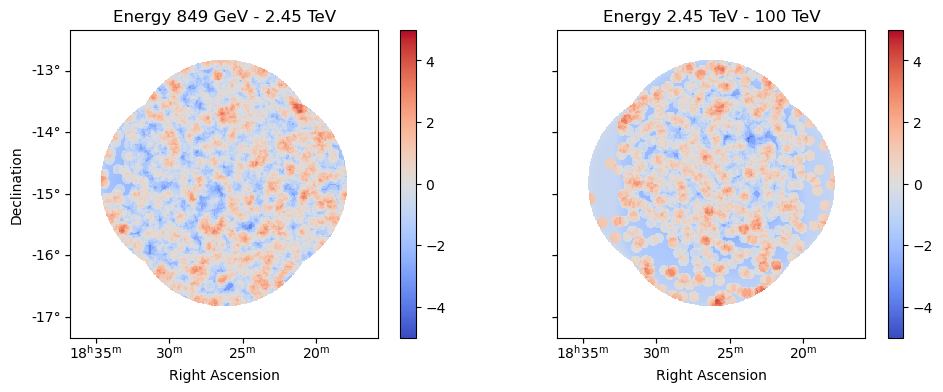

In [30]:
estimator = ExcessMapEstimator(
    correlation_radius="0.089 deg",
    selection_optional=[],
    energy_edges=[ 0.7, 3, 100] * u.TeV,
)

result = estimator.run(dataset_stacked)
result["sqrt_ts"].plot_grid(
    figsize=(12, 4), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
)
plt.savefig("3D-estimator.png")
plt.show()

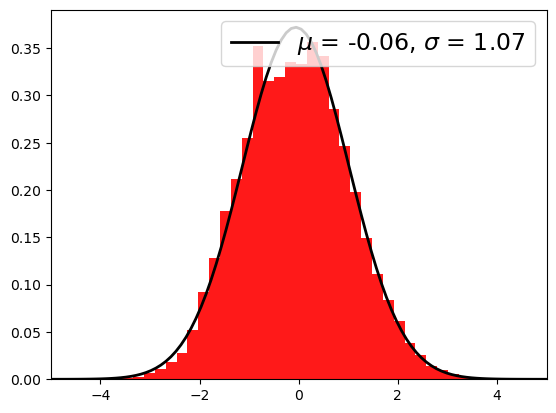

In [31]:
significance_data = result["sqrt_ts"].data

# Remove bins that are inside an exclusion region, that would create an artificial peak at significance=0.
selection = np.isfinite(significance_data)
significance_data = significance_data[selection]

fig, ax = plt.subplots()

ax.hist(significance_data, density=True, alpha=0.9, color="red", bins=40)
mu, std = norm.fit(significance_data)

x = np.linspace(-5, 5, 100)
p = norm.pdf(x, mu, std)

ax.plot(
    x,
    p,
    lw=2,
    color="black",
    label=r"$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(mu, std),
)
ax.legend(fontsize=17)
ax.set_xlim(-5, 5)
fig.savefig("3D_SigDist.png")
plt.show()

# Plotting Energy Spectra
<a id='spectra'></a>

We can plot the energy spectrum for each source using the model object.

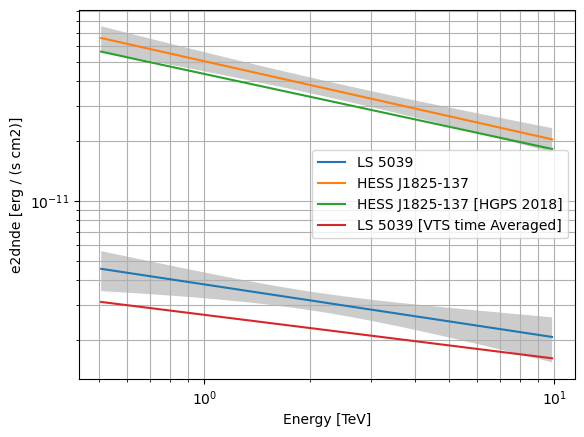

In [32]:

erange = (0.5, 10) * u.TeV

model_HESS_tevcat = PowerLawSpectralModel(
    amplitude = 1.91e-11 / u.TeV / u.cm / u.cm /u.s,
    index = 2.38,
    reference = 1.16 * u.TeV
)


model_ls5024_tevcat = PowerLawSpectralModel(
    amplitude = 1.67e-12 / u.TeV / u.cm / u.cm /u.s,
    index = 2.22,
    reference = 1.0 * u.TeV
)


spectral_model_ls5039.plot(
    energy_bounds = erange,
    label = "LS 5039", sed_type = "e2dnde")
spectral_model_ls5039.plot_error(
    energy_bounds = erange, sed_type = "e2dnde")

spectral_model_hess.plot(
    energy_bounds = erange,
    label = "HESS J1825-137", sed_type = "e2dnde")

spectral_model_hess.plot_error(
    energy_bounds = erange, sed_type = "e2dnde")


model_HESS_tevcat.plot(
    energy_bounds = erange,
    label = "HESS J1825-137 [HGPS 2018]", sed_type = "e2dnde"
)

model_ls5024_tevcat.plot(
    energy_bounds = erange,
    label = "LS 5039 [VTS time Averaged]", sed_type = "e2dnde"
)

plt.grid(which = "both")
plt.legend()
plt.savefig("SpectralComparison.png")

# Summary

* LS 5039 is detected as a point source with a significance of 15.85$\sigma$. This is comparable to the 14.12$\sigma$ obtained from the [RBM Analysis](RBM_Analysis.ipynb) and 13.13$\sigma$ from the [Reflected Region Analysis](Spectrum_LS5039.ipynb).
* HESS J1825-137 is detected as an extended source with a significance of 20.4$\sigma$ and an extension of $\sim$0.4 degrees. The [Reflected Region Analysis](Spectrum_HESS.ipynb) suggests 16.6$\sigma$ however this doesn't take into account the source morphology.
* Both fits show decent agreement with archival and previous analyses, with differences for LS 5039 possibly due to the inclusion of GT factors and advanced analysis techniques.
* The significance distributions show that the fit isn't perfect which might also be a source of discrepencies.